In [1]:
import rasterio
import numpy as np
import os
import shutil
from matplotlib import pyplot as plt
from rasterio.plot import show
import glob
from os.path import join as opj

In [7]:
# ### Data organization
# Goal is to resave files from their downloaded form into the following organization
# to ensure each label file can be matched with the planet data

# data  
#     / processed  
#         / labels  
#             / aoi (area of interest id)  
#                 / date.tif  
#         / planet  
#             / aoi  
#                 / date.tif  
#         / npz  
#             / labels  
#                 / aoi  
#                     date.npz  
#             / planet  
#                 / aoi  
#                     date.npz  

In [3]:
# Helper functions for resaving files
def copy_over_file(full_path, proc_dir, fldr):
    new_name = full_path[-14:]
    fldr_path = opj(proc_dir, fldr)
    make_new_path(fldr_path)
    shutil.copyfile(full_path, opj(fldr_path, new_name))

def make_main_dir(dirname):
    proc_data_dir = opj('data', 'processed',dirname)
    make_new_path(proc_data_dir)
    return proc_data_dir

def make_new_path(new_dir):
    if not os.path.exists(new_dir):
        os.makedirs(new_dir)

### Labels

In [53]:
raw_path = 'data/raw/labels/labels/'
label_files = list({f for f in glob.glob(raw_path + "**/**/**.tif", recursive=True)})

In [38]:
proc_labels_dir = make_main_dir('labels')

for full_path in label_files:
    # Extract folder name
    fldr = full_path.replace(raw_path,"").split('/')[0]
    copy_over_file(full_path, proc_labels_dir, fldr)


In [56]:
#We should have (12 months * 2 years * 55 locations) .tif files
proc_path = 'data/processed/labels/'
proc_files = {f for f in glob.glob(proc_path + "**/**/**.tif", recursive=True)}
n_files = len(proc_files)
assert n_files == 55 * 24

# Remove labels and labels.zip
shutil.rmtree('data/raw/labels')
os.remove('data/raw/labels.zip')

### Planet files (training data)

In [11]:
raw_path = 'data/raw/'
planet_files = list({f for f in glob.glob(raw_path + "planet**/**/PF-SR/**.tif", recursive=True)})

In [12]:
proc_data_dir = make_main_dir('planet')

for full_path in planet_files:
    # remove last 21 chars
    aoi = full_path[-33:-21]
    digits = full_path.replace(raw_path + 'planet.', "")[:3]
    fldr = aoi+'_' + digits
    copy_over_file(full_path, proc_data_dir, fldr)
    

In [15]:
#We should have 2 * 365 .tif files for each AOI
proc_path = 'data/processed/planet/'
proc_files = {f for f in glob.glob(proc_path + "**/**/**.tif", recursive=True)}
n_files = len(proc_files)
print(n_files)
assert n_files == len(os.listdir(proc_path)) * 365 * 2

# Remove remaining raw data
shutil.rmtree('data/raw')

2190


### Save monthly files as npz files

In [10]:
proc_path = opj('data','processed')

for type in ['labels', 'planet']:
    # Only get data for files in planet dir
    for dir in os.listdir(opj(proc_path, 'planet')):
        new_dir = opj('data', 'processed', 'npz', type, dir)
        make_new_path(new_dir)
        # Only get monthly file name from label dir
        for tif_file in os.listdir(opj(proc_path, 'labels', dir)):
            tif_path = opj(proc_path, type, dir, tif_file)
            # read as np ndarrays
            try:
                tif_as_np = rasterio.open(tif_path).read()
            except:
                tif_path = opj(proc_path, type, dir, tif_file.replace('_','-'))
                tif_as_np = rasterio.open(tif_path).read()

            npz_path = opj(new_dir, tif_file.replace('_','-')).replace('.tif', '')
            np.savez_compressed(npz_path, tif_as_np)
            


In [ ]:
# TODO:
# Convert tif data files to uint8 to save storage 
# May need to nornmalize to RGB 0-255 first
# https://stackoverflow.com/questions/46866586/conversion-of-image-type-int16-to-uint8

### Explore dataset

In [3]:
# Label dataset info
def get_info(dataset):
    print("Number of bands:", dataset.count)
    print("Pixels width:", dataset.width)
    print("Pixels height:", dataset.height)
    print("Bounds:", dataset.bounds)
    print("CRS:", dataset.crs)
    print("NUMPY shape:", dataset.read().shape)
    print("NUMPY shape of one band:", dataset.read(1).shape)

def summarize_classes(dataset):
    for class_idx in range(dataset.count):
        print(f'''Class index: {class_idx}. \
            Type: {dataset.dtypes[class_idx]}. \
            Max: {np.max(dataset.read(class_idx+1))}. \
            Min: {np.min(dataset.read(class_idx+1))}. \
            Med: {np.median(dataset.read(class_idx+1))}''')

In [14]:
label_path = 'data/processed/labels/2697_3715_13_20N/2018-01-01.tif'
labels = rasterio.open(label_path)

get_info(labels)
print('')
summarize_classes(labels)

Number of bands: 7
Pixels width: 1024
Pixels height: 1024
Bounds: BoundingBox(left=663106.4999999352, bottom=1822093.4999999925, right=666178.4999999352, top=1825165.4999999925)
CRS: EPSG:32620
NUMPY shape: (7, 1024, 1024)
NUMPY shape of one band: (1024, 1024)

Class index: 0.             Type: uint8.             Max: 255.             Min: 0.             Med: 0.0
Class index: 1.             Type: uint8.             Max: 255.             Min: 0.             Med: 0.0
Class index: 2.             Type: uint8.             Max: 255.             Min: 0.             Med: 255.0
Class index: 3.             Type: uint8.             Max: 0.             Min: 0.             Med: 0.0
Class index: 4.             Type: uint8.             Max: 255.             Min: 0.             Med: 0.0
Class index: 5.             Type: uint8.             Max: 255.             Min: 0.             Med: 0.0
Class index: 6.             Type: uint8.             Max: 0.             Min: 0.             Med: 0.0


In [15]:
# PF-SR contains Surface Reflective (data)
# QA contains metadata on data-gathering process
data_path = 'data/processed/planet/2697_3715_13_20N/2018-01-01.tif'
data = rasterio.open(data_path)

get_info(data)
print('')
summarize_classes(data)

Number of bands: 4
Pixels width: 1024
Pixels height: 1024
Bounds: BoundingBox(left=663106.4999999352, bottom=1822093.4999999925, right=666178.4999999352, top=1825165.4999999925)
CRS: EPSG:32620
NUMPY shape: (4, 1024, 1024)
NUMPY shape of one band: (1024, 1024)

Class index: 0.             Type: int16.             Max: 4316.             Min: 69.             Med: 288.0
Class index: 1.             Type: int16.             Max: 3982.             Min: 255.             Med: 539.0
Class index: 2.             Type: int16.             Max: 3123.             Min: 49.             Med: 263.0
Class index: 3.             Type: int16.             Max: 5973.             Min: 242.             Med: 3344.0


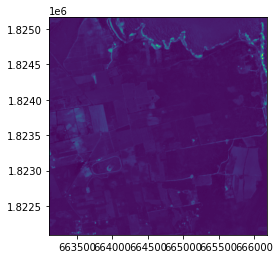

<AxesSubplot:>

In [16]:
rasterio.plot.show(data)

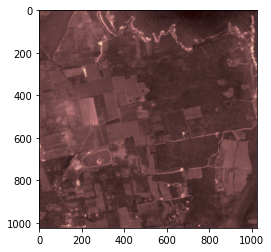

In [17]:
plt.imshow(data.read(2), cmap='pink')


### Plot labels - binary masks

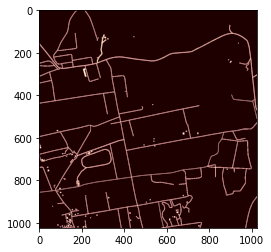

In [18]:
plt.imshow(labels.read(1), cmap='pink')

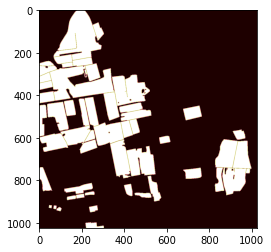

In [19]:
plt.imshow(labels.read(2), cmap='pink')

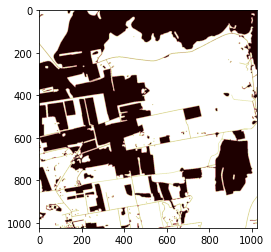

In [20]:
plt.imshow(labels.read(3), cmap='pink')

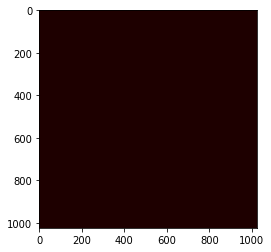

In [21]:
plt.imshow(labels.read(4), cmap='pink')

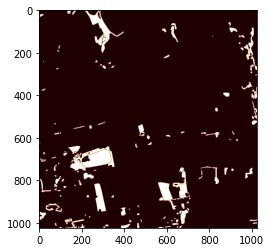

In [22]:
plt.imshow(labels.read(5), cmap='pink')

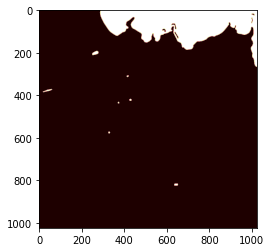

In [23]:
plt.imshow(labels.read(6), cmap='pink')

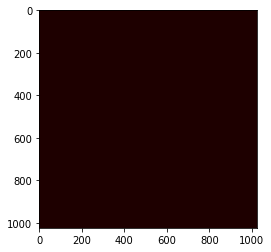

In [24]:
plt.imshow(labels.read(7), cmap='pink')